In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
from pyspark.ml.classification import LogisticRegression

import week4 as w4

## 2. Modelo de Regresión Logística

En esta sección aplicaremos un algoritmo de regresión logística como el visto en el curso 3, para la clasificación de la imágenes de galaxias.

Leemos los datos guardados en el fichero `.parquet`.

In [3]:
df_raw = sqlContext.read.parquet('pca_features.parquet')
df_raw.show(10)

+------------------+------+--------------------+
|          dr7objid|target|        pca_features|
+------------------+------+--------------------+
|587738947743055899|     2|[19.6803262089333...|
|587722982829850800|     2|[-2.3769119439158...|
|587732771049111588|     1|[7.78475874033086...|
|587741722822180915|     1|[-1.1826744292940...|
|587742568935587892|     2|[4.55592541000173...|
|588017606293848123|     1|[-1.5240227079915...|
|587736920508399689|     2|[7.88550662893938...|
|587741600964411477|     2|[7.27102075798117...|
|587733399170515042|     2|[-2.7973181434018...|
|588010360685592719|     2|[-2.0297695896096...|
+------------------+------+--------------------+
only showing top 10 rows



In [5]:
#Reformateamos 'target' a 'double'. De paso mapeamos el valor del target a {0, 1}
#* elíptica = 1 -> 0
#* espiral = 2 -> 1
df = df_raw.withColumn('label', (df_raw['target'] - 1).astype('double'))['dr7objid', 'pca_features', 'label']
df.show(10)

+------------------+--------------------+-----+
|          dr7objid|        pca_features|label|
+------------------+--------------------+-----+
|587738947743055899|[19.6803262089333...|  1.0|
|587722982829850800|[-2.3769119439158...|  1.0|
|587732771049111588|[7.78475874033086...|  0.0|
|587741722822180915|[-1.1826744292940...|  0.0|
|587742568935587892|[4.55592541000173...|  1.0|
|588017606293848123|[-1.5240227079915...|  0.0|
|587736920508399689|[7.88550662893938...|  1.0|
|587741600964411477|[7.27102075798117...|  1.0|
|587733399170515042|[-2.7973181434018...|  1.0|
|588010360685592719|[-2.0297695896096...|  1.0|
+------------------+--------------------+-----+
only showing top 10 rows



### Partición Test - Train

Dividiremos nuestro set de datos en dos subsets más pequeños
* df_train: para el entrenamiento del modelo (Train) con un 70% de los datos
* df_test: para la validación (Test) con un 30% de los datos

In [6]:
(df_train, df_test) = df.randomSplit([0.7, 0.3], seed=123)

### Entrenamiento

In [7]:
lgr = LogisticRegression(maxIter=100,
                         labelCol="label",
                         featuresCol="pca_features",
                         tol=1e-18,
                         regParam=0.003)
                        
model = lgr.fit(df_train)

### Validación

Aplicamos el modelo para generar la predicción

In [23]:
pred_df = model.transform(df_test)
pred_df.columns

['dr7objid',
 'pca_features',
 'label',
 'rawPrediction',
 'probability',
 'prediction',
 'probs']

Comparamos la predicción con la clasificación real

In [9]:
pred_df.select('label','prediction')
cm = w4.confussion_matrix(pred_df, 'label', 'prediction').show()

Recall / Sensitivity / TPR =  0.8705234159779615
Specificity = 1 - FPR =  0.7531172069825436
Precision =  0.8645690834473324
Prevalence =  0.6441881100266194
Accuracy =  0.8287488908606921
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  302|
|  0.0|       1.0|   99|
|  1.0|       0.0|   94|
|  1.0|       1.0|  632|
+-----+----------+-----+



Vemos que todos los indicadores de la bondad del modelo son bastante buenos. En particular podemos destacar que el porcentaje de aciertos (Accuracy) del modelo es del 83%.

También analizaremos la bondad del modelo a través de una curva ROC

In [10]:
pred_df = pred_df.withColumn('probs', w4.ith_element(1)('probability'))

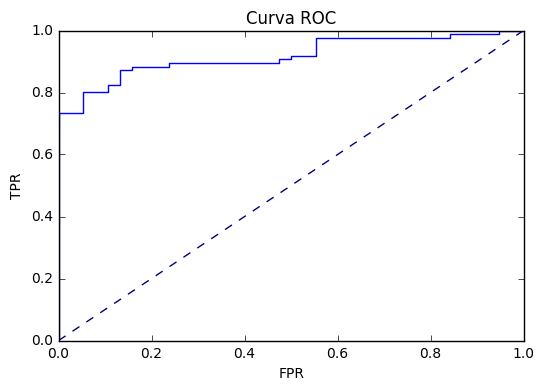

In [11]:
w4.ROC_curve(pred_df)

Y vemos el área por debajo de la curva ROC. 

In [12]:
print('AUC = ', BCE(metricName="areaUnderROC", rawPredictionCol='probability').evaluate(pred_df))

AUC =  0.8976319531749137


Concluyendo que es un buen clasificador sin overfitting